In [1]:
import os
os.environ["CUDE_DEVICE_ORDER"] = "PCI_B_US_ID"
os.environ["CUDA_VISIBLE_DEVICES"] ="3"
import rasterio
import numpy as np
from rasterio.plot import adjust_band
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.plot import show
from itertools import product
from rasterio.windows import Window
from pyproj import Proj, transform
import random
import math
import itertools

In [2]:
label_dataset = rasterio.open('/deep_data/landcover_reproject.tif')
label_image = label_dataset.read()

image_paths = ['/deep_data/processed_landsat/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined.tif',
               '/deep_data/processed_landsat/LC08_CU_028012_20140814_20171017_C01_V01_SR_combined.tif',
               '/deep_data/processed_landsat/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined.tif',  
               '/deep_data/processed_landsat/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined.tif']

landsat_datasets = []
for fp in image_paths:
    landsat_datasets.append(rasterio.open(fp))


In [3]:
def tile_generator(image_datasets, label_dataset, tile_height, tile_width, pixel_locations, batch_size):
    ### this is a keras compatible data generator which generates data and labels on the fly 
    ### from a set of pixel locations, a list of image datasets, and a label dataset
    
    # pixel locations looks like [r, c, dataset_index]
    label_image = label_dataset.read()
    label_image[label_image == 255] = 1

    c = r = 0
    i = 0
    
    outProj = Proj(label_dataset.crs)

    # assuming all images have the same num of bands
    band_count = image_datasets[0].count
    class_count = len(np.unique(label_image))
    buffer = math.ceil(tile_height / 2)
  
    while True:
        image_batch = np.zeros((batch_size, tile_height, tile_width, band_count-1)) # take one off because we don't want the QA band
        label_batch = np.zeros((batch_size,class_count))
        b = 0
        while b < batch_size:
            # if we're at the end  of the data just restart
            if i >= len(pixel_locations):
                i=0
            c, r = pixel_locations[i][0]
            dataset_index = pixel_locations[i][1]
            i += 1
            tile = image_datasets[dataset_index].read(list(np.arange(1, band_count+1)), window=Window(c-buffer, r-buffer, tile_width, tile_height))
            if np.amax(tile) == 0: # don't include if it is part of the image with no pixels
                pass
            elif np.isnan(tile).any() == True or -9999 in tile: 
                # we don't want tiles containing nan or -999 this comes from edges
                # this also takes a while and is inefficient
                pass
            elif tile.shape != (band_count, tile_width, tile_height):
                print('wrong shape')
                print(tile.shape)
                # somehow we're randomly getting tiles without the correct dimensions
                pass
            elif np.isin(tile[7,:,:], [352, 368, 392, 416, 432, 480, 840, 864, 880, 904, 928, 944, 1352]).any() == True:
                # make sure pixel doesn't contain clouds
                # this is probably pretty inefficient but only checking width x height for each tile
                # read more here: https://prd-wret.s3-us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/atoms/files/LSDS-1873_US_Landsat_ARD_DFCB_0.pdf
                #print('Found some cloud.')
                #print(tile[7,:,:])
                pass
            else:
                tile = adjust_band(tile[0:7])
                # reshape from raster format to image format
                reshaped_tile = reshape_as_image(tile)

                # find gps of that pixel within the image
                (x, y) = image_datasets[dataset_index].xy(r, c)

                # convert the point we're sampling from to the same projection as the label dataset if necessary
                inProj = Proj(image_datasets[dataset_index].crs)
                if inProj != outProj:
                    x,y = transform(inProj,outProj,x,y)

                # reference gps in label_image
                row, col = label_dataset.index(x,y)

                # find label
                label = label_image[:, row, col]
                # if this label is part of the unclassified area then ignore
                if label == 0 or np.isnan(label).any() == True:
                    pass
                else:
                    # add label to the batch in a one hot encoding style
                    label_batch[b][label] = 1
                    image_batch[b] = reshaped_tile
                    b += 1
        yield (image_batch, label_batch)


In [4]:
def gen_balanced_pixel_locations(image_datasets, label_image, label_dataset, amount_of_labels, train_count, val_count, tile_size):
    ### this function pulls out a train_count + val_count number of random pixels from a list of raster datasets
    ### and returns a list of training pixel locations and image indices 
    ### and a list of validation pixel locations and indices
    

    train_pixels = []
    val_pixels = []
    train_bucket_size = math.ceil(train_count / (amount_of_labels-6)) # -6 because not enough classes to fill each bucket

    validation_bucket_size = math.ceil(val_count / (amount_of_labels-6)) #not enough classes to fill each bucket

    label_image[label_image == 255] = 1
    train_label_buckets = np.zeros(amount_of_labels)    
    val_label_buckets = np.zeros(amount_of_labels)
    outProj = Proj(label_dataset.crs)

    buffer = math.ceil(tile_size/2)
    
    train_count_per_dataset = math.ceil(train_count / len(image_datasets))
    val_count_per_dataset = math.ceil(val_count / len(image_datasets))
    total_count_per_dataset = train_count_per_dataset + val_count_per_dataset
    
    for index, image_dataset in enumerate(image_datasets):
        #randomly pick `count` num of pixels from each dataset
        
        img_height, img_width = image_dataset.shape
        #rows_sub, columns_sub = zip(*random.sample(list(zip(rows, columns)), total_count))     
        val_points = set()
        train_points = set()

        while len(val_points) != val_count_per_dataset:
            aPoint = (random.randint(0+buffer,img_width-buffer), random.randint(0+buffer,img_height-buffer))
            #print(aPoint)
            #print(val_label_buckets)
            c, r = aPoint
            (x, y) = image_dataset.xy(r, c)
            inProj = Proj(image_dataset.crs)
            if inProj != outProj:
                x,y = transform(inProj,outProj,x,y)
                # reference gps in label_image
            row, col = label_dataset.index(x,y)
            label = label_image[:, row, col]
            if val_label_buckets[label] != validation_bucket_size and label!=1 :
                past_size = len(val_points)
                val_points.add(aPoint)
                if past_size != len(val_points):
                    val_label_buckets[label] +=1
                    
                    
        while len(train_points) != train_count_per_dataset:   
            aPoint = (random.randint(0+buffer,img_width-buffer), random.randint(0+buffer,img_height-buffer))
            c, r = aPoint
            (x, y) = image_dataset.xy(r, c)            
            inProj = Proj(image_dataset.crs)
            #print(train_label_buckets)
            if inProj != outProj:
                x,y = transform(inProj,outProj,x,y)
                # reference gps in label_image
            row, col = label_dataset.index(x,y)
            label = label_image[:, row, col]
            if (train_label_buckets[label] != train_bucket_size) and label!=1:
                past_size = len(train_points)
                train_points.add(aPoint)
                if past_size != len(train_points):
                    train_label_buckets[label] +=1
                    
        train_points = zip(train_points, [index]*train_count_per_dataset)
        val_points = zip(val_points, [index]*val_count_per_dataset)        

        train_pixels += train_points
        val_pixels += val_points
        
        
    return (train_pixels, val_pixels)

In [5]:
def gen_pixel_locations(image_datasets, train_count, val_count, tile_size):
    ### this function pulls out a train_count + val_count number of random pixels from a list of raster datasets
    ### and returns a list of training pixel locations and image indices 
    ### and a list of validation pixel locations and indices
    
    ## future improvements could make this select classes evenly
    train_pixels = []
    val_pixels = []
    
    buffer = math.ceil(tile_size/2)
    
    train_count_per_dataset = math.ceil(train_count / len(image_datasets))
    val_count_per_dataset = math.ceil(val_count / len(image_datasets))
   
    total_count_per_dataset = train_count_per_dataset + val_count_per_dataset
    for index, image_dataset in enumerate(image_datasets):
        #randomly pick `count` num of pixels from each dataset
        img_height, img_width = image_dataset.shape
        
        rows = range(0+buffer, img_height-buffer)
        columns = range(0+buffer, img_width-buffer)
        #rows_sub, columns_sub = zip(*random.sample(list(zip(rows, columns)), total_count))
        
        points = random.sample(set(itertools.product(rows, columns)), total_count_per_dataset)
        
        dataset_index_list = [index] * total_count_per_dataset
        
        dataset_pixels = list(zip(points, dataset_index_list))
        
        train_pixels += dataset_pixels[:train_count_per_dataset]
        val_pixels += dataset_pixels[train_count_per_dataset:]
        
        
    return (train_pixels, val_pixels)

In [6]:
label_image = label_dataset.read()
batch_size = 25
label_image[label_image == 255] = 1
num_classes = len(np.unique(label_image))
epochs = 50

# input image dimensions
tile_side = 64
img_rows, img_cols = tile_side, tile_side
img_bands = landsat_datasets[0].count - 1

input_shape = (img_rows, img_cols, img_bands)
print(input_shape)


(64, 64, 7)


In [7]:
(train_px, val_px) = gen_balanced_pixel_locations(landsat_datasets, label_image, label_dataset, num_classes, 10000, 1000, tile_side)

In [8]:
#USING BALANCED
train_buckets = np.zeros(num_classes)
for i in range(len(train_px)):
        c, r = train_px[i][0]
        (x, y) = landsat_datasets[train_px[i][1]].xy(r, c) 
        outProj = Proj(label_dataset.crs)
        inProj = Proj(landsat_datasets[train_px[i][1]].crs)
         #print(train_label_buckets)
        if inProj != outProj:
            x,y = transform(inProj,outProj,x,y)
             # reference gps in label_image
        row, col = label_dataset.index(x,y)
        label = label_image[:, row, col]
        train_buckets[label] +=1
print("TRAINING BUCKETS")
print(train_buckets)
val_buckets = np.zeros(num_classes)
for i in range(len(val_px)):
        c, r = val_px[i][0]
        (x, y) = landsat_datasets[val_px[i][1]].xy(r, c) 
        outProj = Proj(label_dataset.crs)
        inProj = Proj(landsat_datasets[val_px[i][1]].crs)
         #print(train_label_buckets)
        if inProj != outProj:
            x,y = transform(inProj,outProj,x,y)
             # reference gps in label_image
        row, col =  label_dataset.index(x,y)
        label = label_image[:, row, col]
        val_buckets[label] +=1
print("VALIDATION BUCKETS")
print(val_buckets)

TRAINING BUCKETS
[589.   0. 258. 537. 589. 589. 589. 589. 589. 589. 589. 589. 589. 589.
 589. 589.   0.  20. 308.  42. 589. 589.   0.]
VALIDATION BUCKETS
[59.  0. 23. 52. 59. 59. 59. 59. 59. 59. 59. 59. 59. 59. 59. 59.  0.  3.
 36.  1. 59. 59.  0.]


In [9]:
train2_px, val2_px = gen_pixel_locations(landsat_datasets, 10000, 1000, 64)

In [10]:
#NOT USING BALANCED
train_buckets = np.zeros(num_classes)
for i in range(len(train2_px)):
        c, r = train2_px[i][0]
        (x, y) = landsat_datasets[train2_px[i][1]].xy(r, c) 
        outProj = Proj(label_dataset.crs)
        inProj = Proj(landsat_datasets[train2_px[i][1]].crs)
         #print(train_label_buckets)
        if inProj != outProj:
            x,y = transform(inProj,outProj,x,y)
             # reference gps in label_image
        row, col = label_dataset.index(x,y)
        label = label_image[:, row, col]
        train_buckets[label] +=1
print("TRAINING BUCKETS")
print(train_buckets)
val_buckets = np.zeros(num_classes)
for i in range(len(val2_px)):
        c, r = val2_px[i][0]
        (x, y) = landsat_datasets[val2_px[i][1]].xy(r, c) 
        outProj = Proj(label_dataset.crs)
        inProj = Proj(landsat_datasets[val_px[i][1]].crs)
         #print(train_label_buckets)
        if inProj != outProj:
            x,y = transform(inProj,outProj,x,y)
             # reference gps in label_image
        row, col = label_dataset.index(x,y)
        label = label_image[:, row, col]
        val_buckets[label] +=1
print("VALIDATION BUCKETS")
print(val_buckets)

TRAINING BUCKETS
[1590.    0.   12.   45.  172.  150. 1958.  117.  331.  137. 1140.  150.
  924. 1463.  518.  188.    0.    2.   88.   10.   42.  963.    0.]
VALIDATION BUCKETS
[155.   0.   2.   7.  17.  18. 176.  21.  30.  14. 109.  21.  96. 145.
  55.  15.   0.   1.   7.   1.   3. 107.   0.]


In [11]:
count = 0
for (im, label) in tile_generator(landsat_datasets, label_dataset, 64, 64, train_px, 10):
    if count > 3:
        break
    print('Image')
    print(im.shape)
    print('Label')
    print(label)
    print(label.shape)
    print('----')
    count += 1
    im_batch = im

Image
(10, 64, 64, 7)
Label
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(10, 23)
----
Image
(10, 64, 64, 7)
Label
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

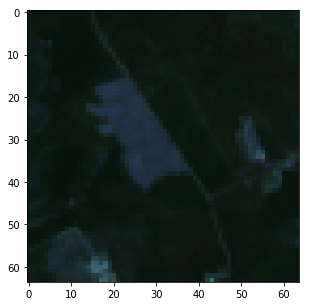

In [12]:
fig, axs = plt.subplots(1, 1, figsize=(18, 5)) 

axs.imshow(im_batch[0,:,:,1:4])

In [14]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

Using TensorFlow backend.


In [15]:
model = Sequential()

model.add(Conv2D(tile_side, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(22, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

#model.summary()

In [16]:
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
metrics=['accuracy']

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=metrics)

In [ ]:
model.fit_generator(generator=tile_generator(landsat_datasets, label_dataset, tile_side, tile_side, train_px, batch_size), 
                    steps_per_epoch=len(train_px) // batch_size, epochs=epochs, verbose=1,
                    validation_data=tile_generator(landsat_datasets, label_dataset, tile_side, tile_side, val_px, batch_size),
                    validation_steps=len(val_px) // batch_size)

Epoch 1/50
400/400 [==============================] - 42s 105ms/step - loss: 2.4729 - acc: 0.1698 - val_loss: 3.8737 - val_acc: 0.0460
Epoch 2/50
400/400 [==============================] - 19s 48ms/step - loss: 2.5056 - acc: 0.1839 - val_loss: 3.9499 - val_acc: 0.0470
Epoch 3/50
400/400 [==============================] - 19s 47ms/step - loss: 2.3817 - acc: 0.1782 - val_loss: 3.4405 - val_acc: 0.0600
Epoch 4/50
400/400 [==============================] - 19s 46ms/step - loss: 2.5864 - acc: 0.1610 - val_loss: 4.1822 - val_acc: 0.0560
Epoch 5/50
400/400 [==============================] - 18s 46ms/step - loss: 2.4394 - acc: 0.1602 - val_loss: 3.0320 - val_acc: 0.0810
Epoch 6/50
400/400 [==============================] - 18s 45ms/step - loss: 2.5084 - acc: 0.1513 - val_loss: 2.9449 - val_acc: 0.1100
Epoch 7/50
400/400 [==============================] - 18s 46ms/step - loss: 2.5773 - acc: 0.1508 - val_loss: 3.0570 - val_acc: 0.0740
Epoch 8/50
400/400 [==============================] - 18s 45m